# Week 5 - Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [2]:
from __future__ import print_function
import os
import pandas as pd
#Data Path has to be set as per the file location in your system
data_path = ['F:\Essential Files\Coding Projects\Machine Learning Class 1']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [3]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['\Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [4]:
print(data.dtypes.value_counts())

float64    561
object       1
dtype: int64


In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [6]:
data.iloc[:,: -1].min().value_counts()

-1.0    561
dtype: int64

In [7]:
data.iloc[:,: -1].max().value_counts()
#Data is already scaled...

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [8]:
print(data.Activity.value_counts())

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64


Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)

In [12]:
data.Activity.sample(n = 5)

939     3
6560    3
2755    1
7034    0
2464    0
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [13]:
# Calculate the correlation values
feature_cols = data.columns[: -1]
corr_vals = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_vals)

# Make the unused values NaNs
for cords in zip(*tril_index):
        corr_vals.iloc[cords[0], cords[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_vals = (corr_vals.stack().to_frame().reset_index().rename(columns={'level_0': 'feature1', 'level1': 'feature2',
                                                                       0: 'correlation'}))

# Get the absolute values for sorting
corr_vals['abs_corr'] = corr_vals.correlation.abs()

A histogram of the absolute value correlations.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Absolute Correlation')]

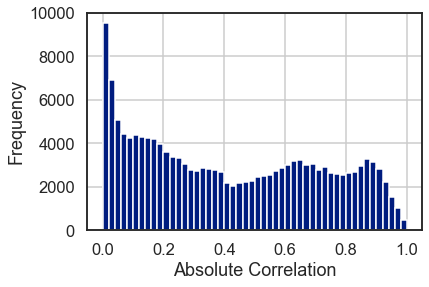

In [15]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_vals.abs_corr.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency')

In [16]:
# The most highly correlated values
df_corr = corr_vals.correlation
print(df_corr.nlargest(30))

92104     1.000000
92112     1.000000
92117     1.000000
92472     1.000000
92831     1.000000
93189     1.000000
93546     1.000000
93897     1.000000
93902     1.000000
94257     1.000000
94611     1.000000
94964     1.000000
95316     1.000000
95667     1.000000
96017     1.000000
96366     1.000000
96706     1.000000
101139    1.000000
105403    1.000000
109498    1.000000
155373    1.000000
156049    1.000000
156556    1.000000
156894    1.000000
50390     1.000000
49927     1.000000
49463     0.999999
118052    0.999864
149731    0.999773
118344    0.999635
Name: correlation, dtype: float64


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train, test = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
x_train = data.loc[train, feature_cols]
y_train = data.loc[train, 'Activity']

x_test = data.loc[test, feature_cols]
y_test = data.loc[test, 'Activity']
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [18]:
from sklearn.linear_model import LogisticRegression

# Mute the sklearn warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')

# Standard logistic regression
lr = LogisticRegression().fit(x_train, y_train)

In [19]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_CV_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(x_train, y_train)

In [20]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [21]:
# L2 regularized logistic regression
lr_CV_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(x_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [22]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_CV_l1, lr_CV_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  if __name__ == '__main__':


lr                                                          l1  \
            0         1         2         3         4         5         0   
298  0.212021 -0.268885  0.373421  0.007680 -0.749080  0.081234  0.000000   
450  0.117520  0.106800 -0.049856  1.519654 -0.136011 -1.264013  0.000000   
369 -0.188240 -0.380597  0.793722  0.486143 -0.482811 -1.161433 -0.145672   
173  0.012576 -0.029623 -0.245612 -0.074203 -0.378928  0.531937  0.000000   
269 -0.040796  0.048655 -0.421074  0.268310 -0.586260  0.306189  0.000000   
194  0.019414  0.580716 -0.802380 -0.578038  0.293138  1.107637  0.000000   
560 -0.188309 -0.298022  0.416920  0.065047 -0.042363  0.438815  0.000000   
353 -0.054494 -0.184109 -0.196497  0.411162 -0.382683 -0.403913  0.000000   
111  0.011999  0.596054 -0.697590  0.034308 -0.245618 -0.413427  0.000000   
325 -0.023566  0.101955 -0.025656 -0.355338 -0.089607 -0.102758 -0.036265   

                                                             l2            \
            1         2         3         4         5         0         1   
298  0.000000  0.000000  0.000000 -1.694599  0.020732  0.592032 -0.013773   
450  0.000000  0.092854  2.050343 -0.109638 -1.352901 -0.109808  0.021925   
369 -0.160352  0.760595  0.642985 -0.071039 -1.314614 -0.649315 -0.475909   
173  0.000000 -0.004703 -0.008066 -0.521787  0.920396  0.046126  0.041925   
269  0.000000 -1.011017  0.584037 -1.714853  1.670807 -0.035318  0.266476   
194  0.000000 -1.481877 -2.759595  0.962072  6.116911  0.162507  0.686688   
560  0.000000  0.000000  0.000000  0.000000  4.154019 -0.448637 -0.281166   
353  0.000000  0.000000  0.661120 -0.650273 -1.376245 -0.138291 -0.278445   
111  2.356725 -3.098799  0.000000 -0.926494 -4.722350  0.198767  1.191611   
325  0.000000  0.000000 -0.812225  0.000000  0.034705 -0.062870  0.092697   

                                             
            2         3         4         5  
298  0.357618  0.125874 -1.346101  1.148555  
450 -0.067180  3.089163 -0.996184 -4.100871  
369  0.862747  0.586525 -0.680007 -4.397815  
173 -0.320672 -0.180266 -1.038416  5.762970  
269 -0.544037  0.984030 -1.406120  1.163823  
194 -1.225901 -1.858295  0.966257  7.674056  
560  0.573336  0.114610 -0.202636  2.835522  
353 -0.247830  1.211117 -1.393360 -3.817597  
111 -1.185728  0.288220 -0.555045 -2.518173  
325 -0.097417 -1.069889 -0.114140 -0.444596

Prepare six separate plots for each of the multi-class coefficients.

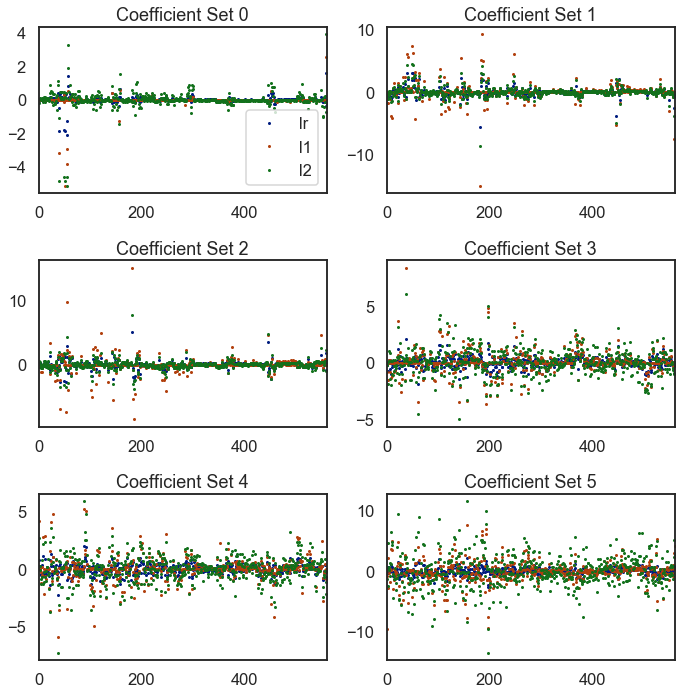

In [23]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set ' +str(loc))
    
plt.tight_layout()
    
    

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [48]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_CV_l1, lr_CV_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(x_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(x_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [49]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:
    
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    accuracy = accuracy_score(y_test, y_pred[lab])
    roc_auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5,]), label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
                           average = 'weighted')
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':roc_auc},
                            name=lab))
    
metrics = pd.concat(metrics, axis=1)

In [50]:
#Run the metrics
print(metrics.head())

                 lr        l1        l2
precision  0.984144  0.983835  0.984148
recall     0.984142  0.983819  0.984142
fscore     0.984143  0.983815  0.984142
accuracy   0.984142  0.983819  0.984142
auc        0.990384  0.990144  0.990361


## Question 8

Display or plot the confusion matrix for each model.

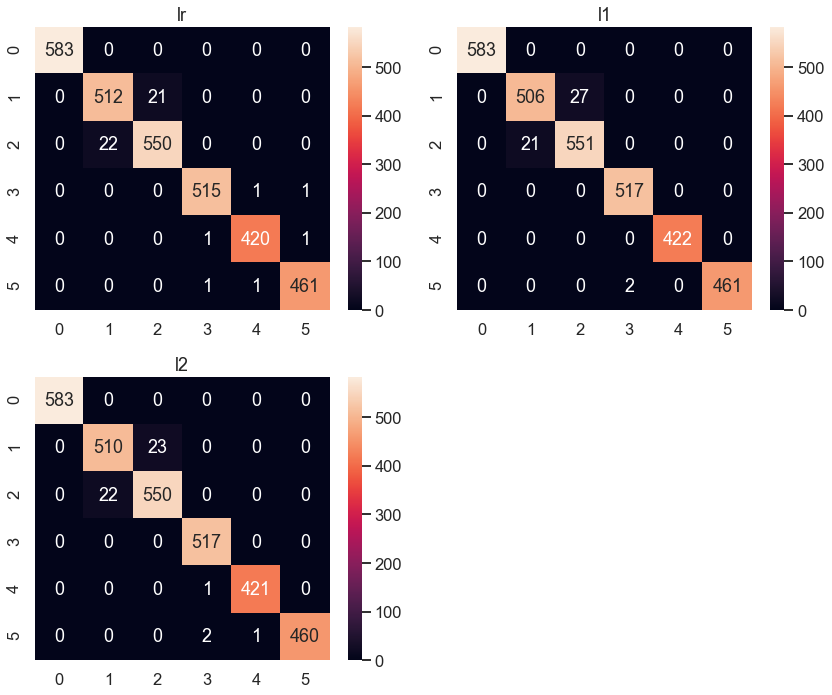

In [51]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax, lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7
sel = VarianceThreshold(threshold=(0.7 * (1-0.7)))


data_new = pd.concat([x_train, x_test])
data_new = sel.fit_transform(data_new)

data_y = pd.concat([y_train, y_test])

from sklearn.model_selection import train_test_split

X_new, X_test_new = train_test_split(data_new)
Y_new, Y_test_new = train_test_split(data_y)

    
    

 Repeat Model building with new training data after removing higly correlated columns

In [53]:
# Try standard, L1 and L2 Logistic regression

lr_2 = LogisticRegression().fit(X_new, Y_new)

lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_new, Y_new)

lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_new, Y_new)

In [54]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [55]:
# Combine all the coefficients into a dataframe for comparison
coefficients_2 = list()

coeff_labels_2 = ['lr', 'l1', 'l2']
coeff_models_2 = [lr_2, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels_2, coeff_models_2):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_2.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_2 = pd.concat(coefficients_2, axis=1)

coefficients_2.sample(10)

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  if __name__ == '__main__':


lr                                                     l1            \
           0         1         2         3         4         5    0    1    2   
3  -0.026856  0.371952 -0.204836 -0.466508  0.193931  0.328302  0.0  0.0  0.0   
17  0.113537  0.014468 -0.347371 -0.061225 -0.234345  0.598353  0.0  0.0  0.0   
41  0.127136  0.304088 -0.231233  0.164388 -0.128717 -0.336315  0.0  0.0  0.0   
18  0.096731 -0.299760 -0.004807  0.189857 -0.131829  0.130531  0.0  0.0  0.0   
45 -0.036134 -0.181949  0.484575  0.034705 -0.554387  0.079883  0.0  0.0  0.0   
24  0.096731 -0.299760 -0.004807  0.189857 -0.131829  0.130531  0.0  0.0  0.0   
43  0.025361 -0.200440 -0.055300  0.452458 -0.153215 -0.075434  0.0  0.0  0.0   
20  0.096731 -0.299760 -0.004807  0.189857 -0.131829  0.130531  0.0  0.0  0.0   
31 -0.249180  0.178845  0.142931 -0.571981  0.633534 -0.062381  0.0  0.0  0.0   
4  -0.025274  0.066752 -0.139483 -0.144668  0.338656 -0.001789  0.0  0.0  0.0   

                         l2                                                    
      3    4    5         0         1         2         3         4         5  
3   0.0  0.0  0.0  0.000199  0.000235 -0.000517  0.000439 -0.000427  0.000018  
17  0.0  0.0  0.0 -0.000179  0.000827 -0.000287 -0.000143 -0.000861  0.000562  
41  0.0  0.0  0.0  0.000005  0.000658 -0.000252  0.001086 -0.000835 -0.000746  
18  0.0  0.0  0.0  0.000237  0.000131 -0.000468  0.000527 -0.000499  0.000019  
45  0.0  0.0  0.0 -0.000096  0.000232  0.000284  0.001108 -0.000962 -0.000651  
24  0.0  0.0  0.0  0.000237  0.000131 -0.000468  0.000527 -0.000499  0.000019  
43  0.0  0.0  0.0 -0.000278  0.000568 -0.000114  0.000681 -0.000656 -0.000294  
20  0.0  0.0  0.0  0.000237  0.000131 -0.000468  0.000527 -0.000499  0.000019  
31  0.0  0.0  0.0  0.000344  0.000300 -0.000123  0.000702 -0.000494 -0.000787  
4   0.0  0.0  0.0 -0.000318  0.000242 -0.000303 -0.000139  0.001007 -0.000534

Prepare six separate plots for each of the multi-class coefficients.

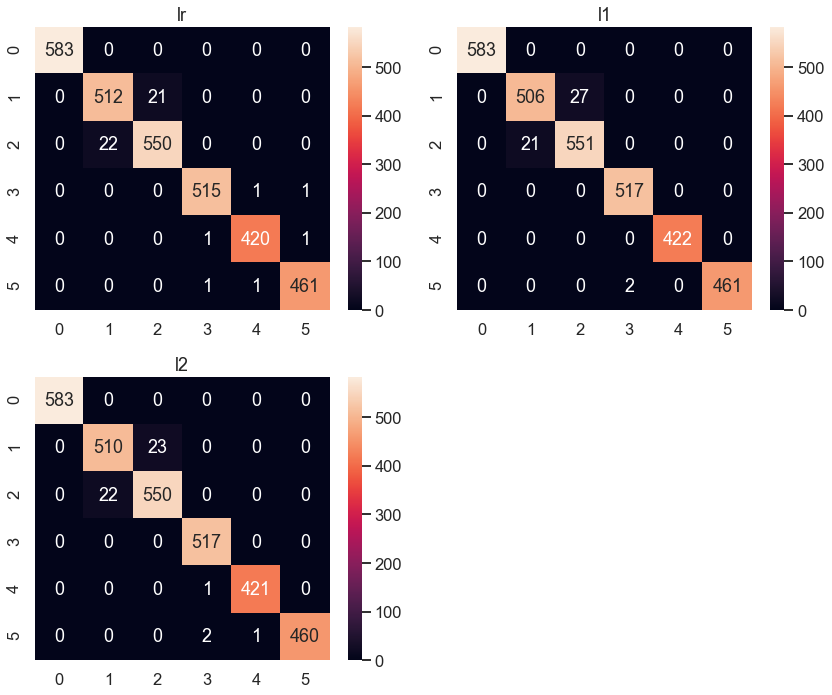

In [56]:
# try the plots
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax, lab in zip(axList[:-1], coeff_labels_2):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)
    
plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [57]:
# Predict the class and the probability for each
y_pred_2 = list()
y_prob_2 = list()

coeff_labels_3 = ['lr', 'l1', 'l2']
coeff_models_3 = [lr, lr_CV_l1, lr_CV_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_2.append(pd.Series(mod.predict(x_test), name=lab))
    y_prob_2.append(pd.Series(mod.predict_proba(x_test).max(axis=1), name=lab))
    
y_pred_2 = pd.concat(y_pred_2, axis=1)
y_prob_2 = pd.concat(y_prob_2, axis=1)

y_pred_2.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [62]:
# Calculate the error metrics as listed above
metrics_2 = list()
cm = dict()

for lab in coeff_labels:
    
    precision, recall, fscore, _ = score(y_test, y_pred_2[lab], average='weighted')
    accuracy = accuracy_score(y_test, y_pred[lab])
    roc_auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5,]), label_binarize(y_pred_2[lab], classes=[0,1,2,3,4,5]),
                           average = 'weighted')
    cm[lab] = confusion_matrix(y_test, y_pred_2[lab])
    
    metrics_2.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':roc_auc},
                            name=lab))
    
metrics_2 = pd.concat(metrics_2, axis=1)

In [63]:
#Run the metrics
print(metrics_2.head())

                 lr        l1        l2
precision  0.984144  0.983835  0.984148
recall     0.984142  0.983819  0.984142
fscore     0.984143  0.983815  0.984142
accuracy   0.984142  0.983819  0.984142
auc        0.990384  0.990144  0.990361


## Question 13

Display or plot the confusion matrix for each model.

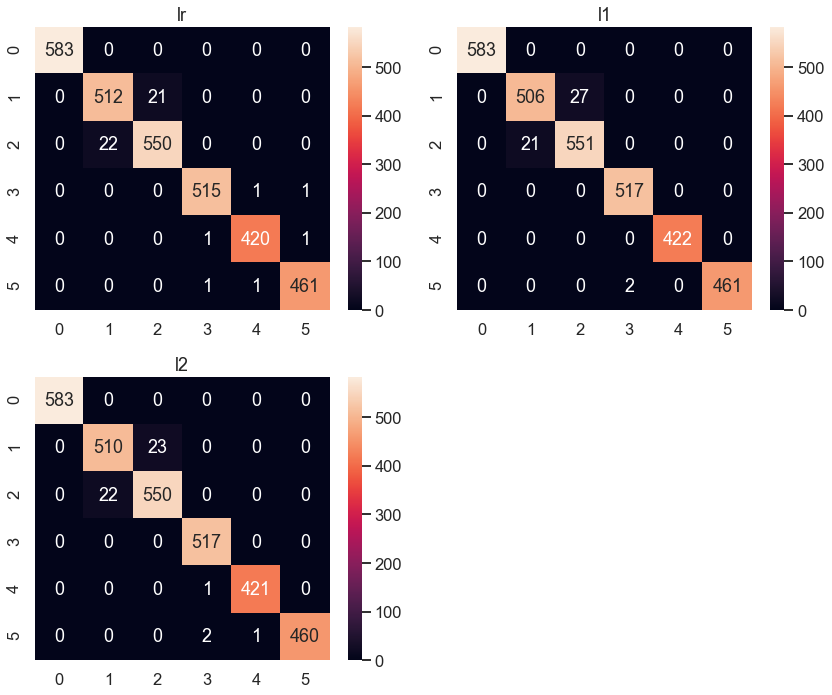

In [64]:
#Plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax, lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)
    
plt.tight_layout()

In [66]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
print(metrics)
print(metrics_2)

                 lr        l1        l2
precision  0.984144  0.983835  0.984148
recall     0.984142  0.983819  0.984142
fscore     0.984143  0.983815  0.984142
accuracy   0.984142  0.983819  0.984142
auc        0.990384  0.990144  0.990361
                 lr        l1        l2
precision  0.984144  0.983835  0.984148
recall     0.984142  0.983819  0.984142
fscore     0.984143  0.983815  0.984142
accuracy   0.984142  0.983819  0.984142
auc        0.990384  0.990144  0.990361


In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation
#The results are the same for both graphs. Something needs to be changed in the code, but I could not determine what the change
#was in order for the results to be different.